# StatsModels의 Kalman Filter 클래스

statsmodels 버전 0.8.1 이상은 상태 공간 모형(space state model)을 위한 statespace 서브패키지내에 동적 선형 모형(DLM: Dynamic Linear Model) 칼만 필터링을 위한 `KalmanFilter` 클래스와 `FilterResults` 클래스를 제공한다. 여기에서는 이 클래스의 사용법을 간단히 소개한다. 보다 자세한 내용은 문서 웹사이트를 참조한다.

* http://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.kalman_filter.KalmanFilter.html
* http://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.kalman_filter.FilterResults.html

이 두 클래스는 모두 `statsmodels.tsa.statespace.representation.Representation` 클래스를 상속한다.

* http://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.representation.Representation.html

## 클래스 임포트

`KalmanFilter`는 버전 0.8.1인 현재 아직 statsmodel.api 서브패키지에 노출되어 있지 않다. 따라서 다음과 같이 직접 클래스를 임포트 해야한다. `FilterResults` 클래스는 필터링 결과로 나오는 것이므로 별도로 임포트할 필요가 없다.

In [1]:
##스타트업 파일

from scipy.stats import norm
import numpy as np
import scipy as sp
from pandas.core import datetools 
import pandas as pd
import statsmodels.api as sm ## R 패키지에서 불러온것, 샘플데이터 옮겨쓸수 있는 프로젝트 있음. 회귀분석에 유용 
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
import sklearn as sk 

import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pylab 
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

import seaborn as sns
sns.set()
sns.set_style("whitegrid")
sns.set_color_codes()

## Anaconda: localhost:8890
## python3: localhost:8888

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  


In [2]:
from statsmodels.tsa.statespace.kalman_filter import KalmanFilter

## 클래스 생성

KalmanFilter 클래스는 다음과 같은 동적 선형 모형 수식을 가정하고 있다.

$$
\begin{eqnarray}
\alpha_t  &=& T_t \alpha_{t-1} + c_t + R_t \eta_t \\
y_t       &=& Z_t \alpha_t + d_t + \varepsilon_t \\
\end{eqnarray}
$$

* $\alpha_t$ : 상태 벡터
* $T$ : transition matrix
* $c$ : state intercept vector
* $R$ : selection matrix
* $\eta_t\sim N(0, Q_t) $ : 이노베이션 과정 벡터
* $Q$ : state covariance matrix


* $y_t$ : 관측 벡터
* $Z$ : design matrix
* $d$ : observation intercept vector
* $\varepsilon_t \sim N(0, H_t)$ : 관측 잡음 벡터
* $H$ : observation covariance matrix


클래스 생성을 위한 입력 인수 목록은 다음과 같다.

| 인수 | 용도 |
|-|-|
|  `k_endog`  | 정수 혹은 배열. 배열인 경우에는 칼만필터를 적용할 실제 시계열 자료. 정수인 경우에는 출력 변수의 수 |
|  `k_states`  | 정수. 상태 변수의 수 |
|  `k_posdef`  | (옵션) 정수. 출력 잡음의 공분산 중 양 한정(positive definite)을 보장하는 차원의 수. 디폴트는 k_states. |
|  `transition`  | (옵션) 상태 전이 행렬(transition matrix). 디폴트는 0.  |
|  `state_intercept`  | (옵션) 상태 전이식의 절편(intercept for the transition equation). 디폴트는 0.  |
|  `selection` | (옵션) 이노베이션 과정에 대한 선택 행렬(selection matrix). 디폴트는 0.   |
|  `state_cov`  | (옵션) 이노베이션 과정의 공분산 행렬. 디폴트는 0.   |
|  `design`  | (옵션) 설계 행렬(design matrix). 디폴트는 0. |
|  `obs_intercept`  | (옵션) 관측식의 절편(intercept for the observation equation). 디폴트는 0. |
|  `obs_cov`  | (옵션) 관측 행렬의 공분산 행렬. 디폴트는 0. |
|  `initial_state`  | (옵션) 배열. 초기 상태 변수 값 |
|  `initialization`  | (옵션) 다음 문자열 중 하나 {`approximate_diffuse`, `stationary`, `known`} (옵션) 상태 변수 초기화 방법 |
|  `initial_variance`  | (옵션) 실수. 초기화 방법이 `approximate_diffuse` 일 경우의 초기 분산 값. 디폴트는 1e6. |
|  `initial_state_cov`  | (옵션) 배열. 초기화 방법이 `known` 일 경우 사용하는 분산 행렬 |
|  `nobs`  | (옵션) 정수. `k_endog`가 정수인 경우에 시계열 자료의 길이를 표시. |
|  `loglikelihood_burn`  | (옵션) 정수. log-likelihood를 기록하지 않는 burn-in 구간의 길이. 디폴트는 0 |
|  `tolerance`  | (옵션) 실수. 상태변수의 수렴 기준. 디폴트는 1e-19. |


예를 들어 다음과 같은 로컬 레벨 모형의 경우,

$$
\begin{eqnarray}
\mu_t &=& \mu_{t-1} + w_t &,\;\;\; & w_t \sim N(0, 10) \\
Y_{t} &=& \mu_{t} + v_t &,\;\;\; & v_t \sim {N}(0, 100) \\
\end{eqnarray}
$$

다음 코드와 같이 모형을 생성할 수 있다.

In [3]:
mod1 = KalmanFilter(k_endog=1, k_states=1,
                    transition=[[1]], selection=[[1]], state_cov=[[10]], 
                    design=[[1]], obs_cov=[[100]])
mod1

In [4]:
np.random.seed(0)
y1, x1 = mod1.simulate(100)

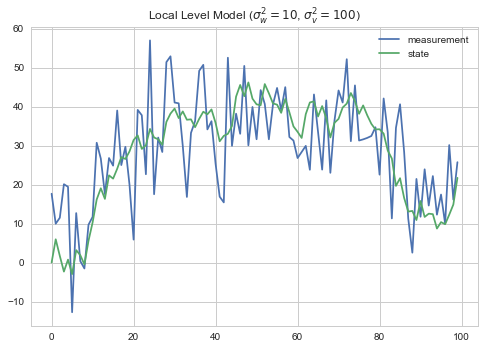

In [5]:
plt.plot(y1, label="measurement")
plt.plot(x1, label="state")
plt.legend()
plt.title("Local Level Model ($\sigma_w^2 = 10$, $\sigma_v^2 = 100$)")
plt.show()
## 파란색은 측정값: 주가 매수매도 스프레드
## 초록색은 실제 상태값:주가 평균

만약 시뮬레이션이 아니라 실제 시계열을 필터링 하는 것이 목적이라면 다음과 같이 관측된 시계열을 넣어 모형을 생성한다.

In [6]:
mod2 = KalmanFilter(y1, k_states=1,
                    transition=[[1]], selection=[[1]], state_cov=[[10]], 
                    design=[[1]], obs_cov=[[100]])
mod2

## 속성

`KalmanFilter` 클래스틑 다음과 같은 속성을 가진다.


| 속성 | 자료형 | 의미 |
|-|-|-|
| `dtype` | `numpy.dtype` | 자료형 |
| `obs` | 배열  |  관측 시계열의 값 | 	
| `endog` |  배열 | 관측 시계열의 값 |
| `time_invariant` | 불리언 | 상태 모형 모수들이 시간에 따라 변화하는가의 여부 | 
| `design` | 배열  | 입력시 지정값 | 	 
| `obs_cov` |  배열 | 입력시 지정값 | 	 
| `obs_intercept` | 배열  | 입력시 지정값 | 	 
| `selection` | 배열 | 입력시 지정값 | 	 
| `state_cov` | 배열  | 입력시 지정값 | 	 
| `state_intercept` | 배열  | 입력시 지정값 | 	 
| `transition` | 배열  | 입력시 지정값 | 	 

## 메서드

`KalmanFilter` 클래스에서 많이 사용되는 메서드 목록은 다음과 같다.


| 메서드 | 기능 |
|-|-|
| `simulate` | 모수가 모두 충족된 경우 시뮬레이션 수행 |
| `initialize_known` | 초기 상태 생성 (상태값을 아는 경우) |
| `initialize_stationary` | 초기 상태 생성 (정상 상태) |
| `initialize_approximate_diffuse` | 초기 상태 생성 |
| `filter` | 필터링.  `FilterResults` 객체 출력 |


시뮬레이션 방법은 위에서 보였다. 필터링의 경우에는 `filter` 메서드를 실행하기에 앞서 `initialize_xxxx` 메소드들로 초기 상태를 생성해야 한다.

In [7]:
mod2.initialize_known([0], [[1]])
res2 = mod2.filter()
res2

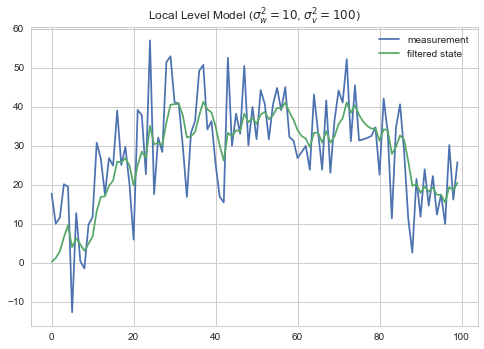

In [8]:
plt.plot(mod2.obs[0], label="measurement")
plt.plot(res2.filtered_state[0], label="filtered state")
plt.legend()
plt.title("Local Level Model ($\sigma_w^2 = 10$, $\sigma_v^2 = 100$)")
plt.show()
## 파란색 측정치:GPS의 오리지널신호 
## 초록색 필터링된 상태: GPS의 표시상태
